## Tridiagonal linear systems
The purpose of the *tridiag.jl* file is to provide the ability to set up and solve tridiagonal linear systems. A tridiagonal matrix is a sparse matrix of the form
$$T = \left[\begin{array}{ccccc}a_1&c_1&&&\\ b_1&a_2&c_2&&\\ &b_2&a_3&\ddots&\\ &&\ddots&\ddots&c_{n-1}\\&&&b_{n-1}&a_n  \end{array}\right]$$
We can solve linear systems of the form $T{\bf x} = {\bf b}$ in $O(n)$ floating point operations in $O(n)$ memory. 

The solution can be computed by forming the LU factorization of the tridiagonal matrix. 

In [2]:
include("tridiag.jl")
using .TDG
using LinearAlgebra
names(TDG)

5-element Array{Symbol,1}:
 :*       
 :TDG     
 :Tridiag 
 :lufact! 
 :lusolve!

The *lufact!* function computes the LU factorization of a tridiagonal matrix. A common test matrix that occurs often in practice is the matrix with 2 on the diagonals and $-1$ on the non-zero off-diagonals. 

In [4]:
n = 10
a = 2*ones(n)
b = -ones(n-1)
c = -ones(n-1)
td = Tridiag(a,b,c)
println("td = ",td)
td2 = deepcopy(td)
lufact!(td2)
println("factored matrix (compact form) = ",td2)
# create a linear system, solve it, and check the solution
sol = randn(n) # random solution
rhs = td*sol   # right-hand side; this is a matrix-vector product
x = copy(rhs)
println("check of solution: norm of reconstruction error = ",norm(td*sol-rhs))
# now solve
lusolve!(td2,x) # in place
# now check soluton
println("error in solution = ",norm(sol-x))
println("reconstruction error = ",norm(td*x-rhs))

td = Tridiag{Float64}([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
factored matrix (compact form) = Tridiag{Float64}([2.0, 1.5, 1.33333, 1.25, 1.2, 1.16667, 1.14286, 1.125, 1.11111, 1.1], [-0.5, -0.666667, -0.75, -0.8, -0.833333, -0.857143, -0.875, -0.888889, -0.9], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
check of solution: norm of reconstruction error = 0.0
error in solution = 4.400993116668346e-15
reconstruction error = 8.08254562088053e-16


# A one-dimensional convection/diffusion/reaction problem
Consider the differential equation
$$D\frac{d^2u}{dx^2} - v\frac{du}{dx} - r\,u = 0 $$
with boundary conditions $u(0)=1$ and $du/dx(L) = 0$.

We use the standard difference approximation for $d^2u/dx^2$: $(u(x_{i+1}-2u(x_i)+u(x_{i-1}))/h^2$ where $h$ is the grid spacing. For $du/dx$ we can use

* $(u(x_{i+1})-u(x_{i-1}))/(2h)$ centered differences
* $(u(x_i)-u(x_{i-1}))/h$ upwind differences
* $(u(x_{i+1})-u(x_i))/h$ downwind differences

The first and last rows of the tridiagonal system are different: $u(x_0)=1$, and for the flux condition $(u(x_N)-u(x_{N-1})=0$.

We start with $D=v=r=1$ and $L=1$. Then we look at the case with small $D$ and (relatively) large $v$ - the convection dominated case.

length of a = 41, of b = 40, of c = 40
check solution: 4.598348030064927e-12


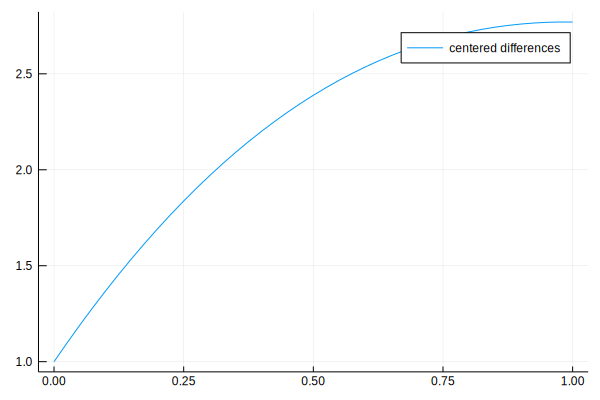

In [4]:
using Plots
D = v = r = L = 1.0
N = 40
h = L/N
xlist = [0:N;]*h
a = [1.0; 2D*ones(N-1)/h^2 .- r; 1.0]
# centered differences
b = [-ones(N-1)/h^2 .+ v/(2h); -1.0]
c = [ 0.0; -ones(N-1)/h^2 .- v/(2h)]
println("length of a = ",length(a),", of b = ",length(b),", of c = ",length(c))
td = Tridiag(a,b,c)
td2 = deepcopy(td)
lufact!(td2)
rhs = [1.0; zeros(N)]
sol = copy(rhs)
lusolve!(td2,sol)
println("check solution: ",norm(td*sol-rhs))
plot(xlist,sol,label="centered differences")

Now we'll repeat the task but with $D = 0.1$ and $v=10$.

length of a = 41, of b = 40, of c = 40
check solution: 4.8408771289005704e-12


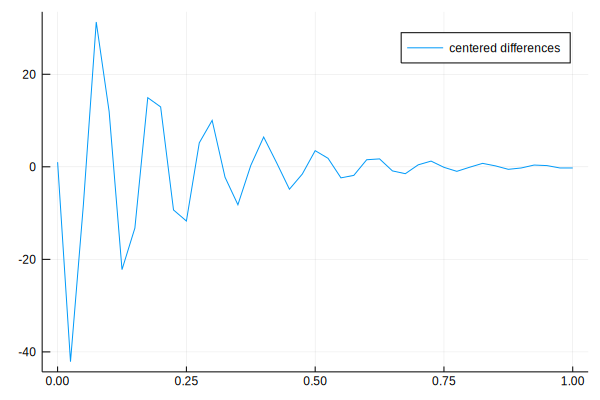

In [5]:
D = 0.1; v = 10.0; r = L = 1.0
N = 40
h = L/N
xlist = [0:N;]*h
a = [1.0; 2D*ones(N-1)/h^2 .- r; 1.0]
# centered differences
b = [-ones(N-1)/h^2 .+ v/(2h); -1.0]
c = [ 0.0; -ones(N-1)/h^2 .- v/(2h)]
println("length of a = ",length(a),", of b = ",length(b),", of c = ",length(c))
td = Tridiag(a,b,c)
td2 = deepcopy(td)
lufact!(td2)
rhs = [1.0; zeros(N)]
sol = copy(rhs)
lusolve!(td2,sol)
println("check solution: ",norm(td*sol-rhs))
plot(xlist,sol,label="centered differences")

Clearly this is not right. There is oscillation in the solution that is completely spurious. (You can repeat with $N=80$, for example, and the oscillation is even more pronounced, and with double the frequency.) So we should try using upwind and downwind differencing.

length of a = 41, of b = 40, of c = 40
check solution: 2.909860655342439e-12
length of a = 41, of b = 40, of c = 40
check solution: 7.468270833359867e-13


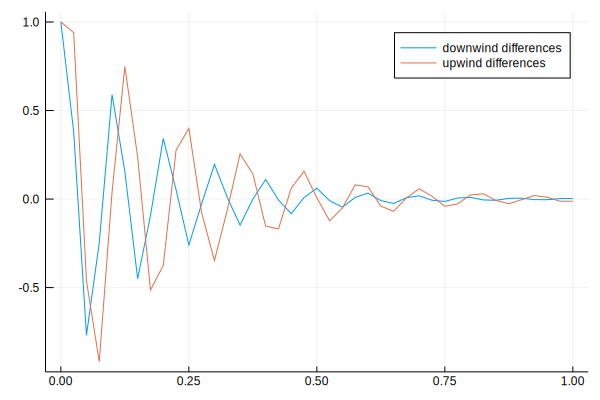

In [9]:
a = [1.0; 2D*ones(N-1)/h^2 .- v/h .- r; 1.0]
# centered differences
b = [-ones(N-1)/h^2 .+ v/h; -1.0]
c = [ 0.0; -ones(N-1)/h^2]
println("length of a = ",length(a),", of b = ",length(b),", of c = ",length(c))
td = Tridiag(a,b,c)
td2 = deepcopy(td)
lufact!(td2)
rhs = [1.0; zeros(N)]
sol = copy(rhs)
lusolve!(td2,sol)
println("check solution: ",norm(td*sol-rhs))
plot(xlist,sol,label="downwind differences")
a = [1.0; 2D*ones(N-1)/h^2 .+ v/h .- r; 1.0]
# centered differences
b = [-ones(N-1)/h^2; -1.0]
c = [ 0.0; -ones(N-1)/h^2 .- v/h]
println("length of a = ",length(a),", of b = ",length(b),", of c = ",length(c))
td = Tridiag(a,b,c)
td2 = deepcopy(td)
lufact!(td2)
rhs = [1.0; zeros(N)]
sol = copy(rhs)
lusolve!(td2,sol)
println("check solution: ",norm(td*sol-rhs))
plot!(xlist,sol,label="upwind differences")